# **Credit Card Fraud Detection using Scikit-Learn and Snap ML**


Snap ML is a high-performance IBM library for ML modeling. It provides highly-efficient CPU/GPU implementations of linear models and tree-based models. Snap ML not only accelerates ML algorithms through system awareness, but also offers novel ML algorithms with best-in-class accuracy. 

In this project, I will consolidate your machine learning (ML) modeling skills by using two popular classification models to recognize fraudulent credit card transactions. These models are: Decision Tree and Support Vector Machine. You will use a real dataset to train each of these models. The dataset includes information about transactions made by credit cards in September 2013 by European cardholders. This will use the trained model to assess if a credit card transaction is legitimate or not.

# Objective 

* Perform basic data preprocessing in Python
* Model a classification task using the Scikit-Learn and Snap ML Python APIs
* Train Suppport Vector Machine and Decision Tree models using Scikit-Learn and Snap ML
* Run inference and assess the quality of the trained models

# Installing Required Libraries

However, if you run this notebook commands in a different Jupyter environment (e.g. Watson Studio or Anaconda), you will need to install these libraries by removing the # sign before !mamba in the code cell below.

In [6]:
!pip install snapml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 2.4 MB/s eta 0:00:00


# Importing Required Libraries

It is important that in this project, all required libraries are imported (in one place down below):

In [7]:
# import libraries needed in this lab
import warnings
warnings.filterwarnings('ignore')

# from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score
import time
import gc, sys

# Introduction

Imagine that you work for a financial institution and part of your job is to build a model that predicts if a credit card transaction is fraudulent or not. You can model the problem as a binary classification problem (*zeros and ones*). A transaction belongs to the positive class (1) if it is a fraud, otherwise it belongs to the negative class (0).

As a Data Scientist, you have access to transactions that occured over a certain period of time. The majority of the transactions are normally legitimate and only a small fraction are non-legitimate. Thus, typically you have access to a dataset that is highly unbalanced. This is also the case of the current dataset: only 492 transactions out of 284,807 are fraudulent (the positive class - the frauds - accounts for 0.172% of all transactions).

To train the model you can use part of the input dataset and the remaining data can be used to assess the quality of the trained model. First, let's download the dataset.

The dataset is the Credit Card Fraud Detection dataset from Kaggle.
https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsIBMGPXX0RHPEN82-2022-01-01

In [9]:
!pip install skillsnetwork

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.2 MB/s eta 0:00:00


In [10]:
import skillsnetwork
await skillsnetwork.prepare("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0RHPEN/data/creditcard.tgz", overwrite=True)

  0%|          | 0/2 [00:00<?, ?it/s]

Saved to '.'


# Dataset Analysis

Here you will read the dataset in a Pandas dataframe and visualize its content. You will also look at some data statistics.

*Pandas dataframe is a two-dimensional, size-mutable, potentially heterogeneous tabular data structure.*

In [12]:
# read the input data
raw_data = pd.read_csv('creditcard.csv')
print("There are " + str(len(raw_data)) + " observations in the credit card fraud dataset.")
print("There are " + str(len(raw_data.columns)) + " variables in the dataset.") # Time,  V1-V28 , Amount, Class

# display the first rows in the dataset
raw_data.head() # print table

There are 284807 observations in the credit card fraud dataset.
There are 31 variables in the dataset.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Financial institutions have access to a much larger dataset of transactions. To simulate such a case, you can inflate the original one 10 times.

That can be done by:

In [13]:
n_replicas = 10

# inflate the original dataset
big_raw_data = pd.DataFrame(np.repeat(raw_data.values, n_replicas, axis=0), columns=raw_data.columns)

print("There are " + str(len(big_raw_data)) + " observations in the inflated credit card fraud dataset.")
print("There are " + str(len(big_raw_data.columns)) + " variables in the dataset.")

# display first rows in the new dataset
big_raw_data.head()

There are 2848070 observations in the inflated credit card fraud dataset.
There are 31 variables in the dataset.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
2,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
3,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
4,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0


Each row in the dataset represents a credit card transaction. As shown above, each row has 31 variables. One variable (last variable) is called Class and represents the target variable. Your objective will be to train a model that uses the other variables to predict the value of the Class variable. Let's first retrieve basic statistics about the target variable.


*For confidentiality reasons, the original names of most features are anonymize as V1, V2 .. V28. The values of these features are the result of a PCA transformation and are numerical. The feature Class is the target variable and it takes two values: 1 in case of fraud and 0 otherwise.*

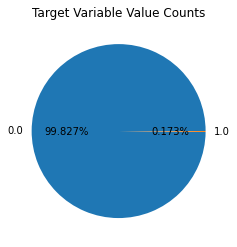

In [14]:
# get the set of distinct classes
labels = big_raw_data.Class.unique()

# get the count of each class
sizes = big_raw_data.Class.value_counts().values

# plot the class value counts
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.3f%%')
ax.set_title('Target Variable Value Counts')
plt.show()

As shown above, the Class variable has two values:

- 0 (the credit card transaction is legitimate)  
- 1 (the credit card transaction is fraudulent)

Thus, you need to model a binary classification problem. Moreover, **the dataset is highly unbalanced**, the target variable classes are not represented equally. This case requires special attention when training or when evaluating the quality of a model. One way of handing this case at training time is to _bias the model to pay more attention to the samples in the minority class_. The models under the current study will be configured to take into account the class weights of the samples at train/fit time.

The credit card transactions have different amounts. You could plot a histogram that shows the distribution of these amounts along with the range of these amounts (min/max) anc can print the 90th percentile of the amount values.

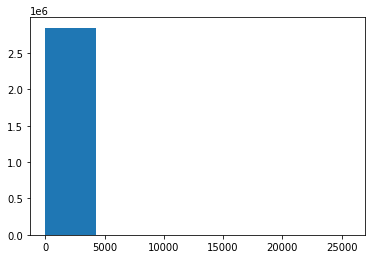

Minimum amount value is  0.0


Maximum amount value is  25691.16


90% of the transactions have an amount less or equal than  203.0


In [18]:
# plot the histrogram that shows distribution
plt.hist(big_raw_data.Amount.values, 6, histtype='bar')
plt.show()

# Range
print("Minimum amount value is ", np.min(big_raw_data.Amount.values))
print("\n")
print("Maximum amount value is ", np.max(big_raw_data.Amount.values))
print("\n")

# 90th percentile of the amount values
print("90% of the transactions have an amount less or equal than ", np.percentile(raw_data.Amount.values, 90))

# Dataset Preprocessing
Data preprocessing such as scaling/normalization is typically useful for linear models to accelerate the training convergence. We standardize features by removing the mean and scaling to unit variance.

In [25]:
big_raw_data.iloc[:, 1:30] = StandardScaler().fit_transform(big_raw_data.iloc[:, 1:30])
data_matrix = big_raw_data.values

# X: feature matrix (for this analysis, we exclude the Time variable from the dataset)
X = data_matrix[:, 1:30]

# y: labels vector
y = data_matrix[:, 30]

# data normalization
X = normalize(X, norm="l1")

# print the shape of the features matrix and the labels vector
print('X.shape =', X.shape)
print('y.shape =', y.shape) 

X.shape = (2848070, 29)
y.shape = (2848070,)


Since this project is dealing with a large dataset, try not do not run out of memory. We can release the memory occupied by raw_data and big_raw_data as we do not need them anymore.

In [26]:
del raw_data
del big_raw_data
gc.collect()

10579

# Dataset Train/Test Split
Now that the dataset is ready for building the classification models, you need to first divide the pre-processed dataset into a subset to be used for training the model (train set) and a subset to be used for evaluating the quality of the model (test set).

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)       
print('X_train.shape=', X_train.shape, 'and Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'and Y_test.shape=', y_test.shape)

X_train.shape= (1993649, 29) and Y_train.shape= (1993649,)
X_test.shape= (854421, 29) and Y_test.shape= (854421,)


# Decision Trees
Let's first use Decision Trees for the problem and evaluate the performance of the classifiers from Scikit-learn and Snap ML.

# Build a Decision Tree Classifier with Scikit-Learn
Compute the sample_weights to be used as input to the training routine so that it takes into account the class imbalance present in this dataset.

In [30]:
w_train = compute_sample_weight('balanced', y_train)
w_train

array([0.50086524, 0.50086524, 0.50086524, ..., 0.50086524, 0.50086524,
       0.50086524])

Import the Decision Tree Classifier Model from scikit-learn:

In [31]:
from sklearn.tree import DecisionTreeClassifier

For reproducible output across multiple function calls, set random_state to a given integer value:

In [34]:
sklearn_dt = DecisionTreeClassifier(max_depth=4, random_state=35)
# sklearn_dt

Train a Decision Tree Classifier using scikit-learn and use the function time to record the training time of our Decision Tree model.

In [35]:
t0 = time.time()
sklearn_dt.fit(X_train, y_train, sample_weight=w_train)
sklearn_time = time.time()-t0
print("[Scikit-Learn] Training time (s):  {0:.5f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  60.29862


# Build a Decision Tree Classifier with Snap ML
Let's import the Decision Tree Classifier Model from Snap ML. Reuse the same sample weights that can be computed before using the Scikit-learn's compute_sample_weight function for training the Decision Tree from Snap ML. The seamless integration of the Snap ML library is possible due to its Scikit-learn Python API compatibility.

Import the Decision Tree Classifier Model from Snap ML:

In [36]:
from snapml import DecisionTreeClassifier

Snap ML offers multi-threaded CPU/GPU training of decision trees, unlike scikit-learn. To use the GPU, set the parameter `use_gpu = True`:

`snapml_dt = DecisionTreeClassifier(max_depth=4, random_state=45, use_gpu=True)`

To set the number of CPU threads used at training time, set the `n_jobs` parameter. For reproducible output across multiple function calls, set `random_state` to a given integer value.

In [39]:
snapml_dt = DecisionTreeClassifier(max_depth=4, random_state=45, n_jobs=4)
# snapml_dt

Train a Decision Tree Classifier from Snap ML and use the function **time** to record the training time.

In [40]:
# train a Decision Tree Classifier model using Snap ML
t0 = time.time()
snapml_dt.fit(X_train, y_train, sample_weight=w_train)
snapml_time = time.time()-t0
print("[Snap ML] Training time (s):  {0:.5f}".format(snapml_time))

[Snap ML] Training time (s):  6.55507


# Evaluate the Scikit-Learn and Snap ML Decision Tree Classifiers
Let's examine the Snap ML vs Scikit-Learn training speedup for the Decision Tree Classifier:

In [41]:
# Snap ML vs Scikit-Learn training speedup
training_speedup = sklearn_time/snapml_time
print('[Decision Tree Classifier] Snap ML vs. Scikit-Learn speedup : {0:.2f}x '.format(training_speedup))

[Decision Tree Classifier] Snap ML vs. Scikit-Learn speedup : 9.20x 


Let's run inference on both classifiers and compute the probabilities of the test samples belonging to the class of fraudulent transactions.

In [47]:
sklearn_pred = sklearn_dt.predict_proba(X_test)[:,1]
snapml_pred = snapml_dt.predict_proba(X_test)[:,1]
# snapml_pred

Evaluate the Compute Area Under the Receiver Operating Characteristic Curve, the **ROC-AUC** score of the predictions of both classifiers:

In [48]:
sklearn_roc_auc = roc_auc_score(y_test, sklearn_pred)
print('[Scikit-Learn] ROC-AUC score : {0:.3f}'.format(sklearn_roc_auc))

snapml_roc_auc = roc_auc_score(y_test, snapml_pred)   
print('[Snap ML] ROC-AUC score : {0:.3f}'.format(snapml_roc_auc))

[Scikit-Learn] ROC-AUC score : 0.966
[Snap ML] ROC-AUC score : 0.966


As shown above, both Decision Tree classifiers provide the same score on the test dataset. 

However Snap ML runs the training routine multiple times faster than Scikit-Learn. This is one of the advantages of using Snap ML: **acceleration of training of classical machine learning models, such as linear and tree-based models**.

# Support Vector Machines
We now use the Support Vector Machine (SVM) models for the problem and evaluate the performance of the models from Scikit-learn and Snap ML.

# Build a Support Vector Machine model with Scikit-Learn
Import the linear Support Vector Machine (SVM) model from Scikit-Learn:

In [49]:
from sklearn.svm import LinearSVC

To indicate the class imbalance at training time, set class_weight='balanced' with scikit-learn SVM model

In [53]:
sklearn_svm = LinearSVC(class_weight='balanced', random_state=31, loss="hinge", fit_intercept=False)
# sklearn_svm

In [54]:
t0 = time.time()
sklearn_svm.fit(X_train, y_train)
sklearn_time = time.time() - t0
print("[Scikit-Learn] Training time (s):  {0:.2f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  135.90


# Build a Support Vector Machine model with Snap ML
Import the Support Vector Machine model (SVM) from Snap ML:

In [55]:
from snapml import SupportVectorMachine

In contrast to scikit-learn's LinearSVC, Snap ML offers multi-threaded CPU/GPU training of SVMs. To use the GPU, set `use_gpu = True`. To set the number of threads used at training time, one needs to set the `n_jobs` parameter.

In [56]:
snapml_svm = SupportVectorMachine(class_weight='balanced', random_state=25, n_jobs=4, fit_intercept=False)
print(snapml_svm.get_params())

{'class_weight': 'balanced', 'device_ids': [], 'fit_intercept': False, 'gamma': 1.0, 'generate_training_history': None, 'intercept_scaling': 1.0, 'kernel': 'linear', 'loss': 'hinge', 'max_iter': 1000, 'n_components': 100, 'n_jobs': 4, 'normalize': False, 'random_state': 25, 'regularizer': 1.0, 'tol': 0.001, 'use_gpu': False, 'verbose': False}


Train an SVM model using Snap ML:

In [57]:
t0 = time.time()
model = snapml_svm.fit(X_train, y_train)
snapml_time = time.time() - t0
print("[Snap ML] Training time (s):  {0:.2f}".format(snapml_time))

[Snap ML] Training time (s):  21.27


# Evaluate the Scikit-Learn and Snap ML Support Vector Machine Models
Let's examine the Snap ML vs Scikit-Learn training speedup for the SVM models:

In [58]:
# compute the Snap ML vs Scikit-Learn training speedup
training_speedup = sklearn_time/snapml_time
print('[Support Vector Machine] Snap ML vs. Scikit-Learn training speedup : {0:.2f}x '.format(training_speedup))

[Support Vector Machine] Snap ML vs. Scikit-Learn training speedup : 6.39x 


Let's run inference on both models and get the confidence scores of the test samples.

In [60]:
sklearn_pred = sklearn_svm.decision_function(X_test)
snapml_pred = snapml_svm.decision_function(X_test)

We evaluate the **ROC-AUC** score of the predictions of both models:

In [62]:
acc_sklearn  = roc_auc_score(y_test, sklearn_pred)
print("[Scikit-Learn] ROC-AUC score: {0:.3f}".format(acc_sklearn))

acc_snapml  = roc_auc_score(y_test, snapml_pred)
print("[Snap ML] ROC-AUC score: {0:.3f}".format(acc_snapml))

[Scikit-Learn] ROC-AUC score: 0.984
[Snap ML] ROC-AUC score: 0.985


As shown above both SVM models provide the same score on the test dataset. However, as in the case of Decision Trees, Snap ML runs the training routine faster than Scikit-Learn. For more Snap ML examples, please visit here.

Moreover, as shown above, not only is Snap ML seemlessly accelerating scikit-learn applications, but the library's Python API is also compatible with scikit-learn metrics and data preprocessors.

- Run inference on the test set using both Scikit-Learn and Snap ML models. 
- Evaluate the quality of the SVM models trained above using the hinge loss metric. 
- Compute and print the hinge loss metric for both sets of predictions **(the two models should give the similar Hinge loss)**.

In [64]:
from sklearn.metrics import hinge_loss

# get confidence scores for test samples
sklearn_pred = sklearn_svm.decision_function(X_test)
snapml_pred  = snapml_svm.decision_function(X_test)
# print(sklearn_pred)
# print(snapml_pred)

# evaluate hinge loss metric for Sklearn
loss_sklearn = hinge_loss(y_test, sklearn_pred)
print("[Scikit-Learn] Hinge loss: {0:.3f}".format(loss_sklearn))

# evaluate hinge loss for Snap ML
loss_snapml = hinge_loss(y_test, snapml_pred)
print("[Snap ML] Hinge loss: {0:.3f}".format(loss_snapml))

[Scikit-Learn] Hinge loss: 0.234
[Snap ML] Hinge loss: 0.228
